In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from regions import Regions
import numpy as np
from astropy import units as u
from astropy.nddata import Cutout2D
import pandas as pd
import cv2
from split_image import split_image
import os
import random
from random import seed
import shutil
from skimage.io import imread,imshow
from skimage.transform import resize
from tqdm import tqdm
import tensorflow as tf
import tensorboard

# Loading the fits file

In [2]:
hdul = fits.open('../../data files/ngc0628_miri_f770w_anchored.fits')
regions = Regions.read('../../data files/jwst-bubbles-v0p1.reg',format='ds9')
hdul.info()

Filename: ../../data files/ngc0628_miri_f770w_anchored.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (2968, 2938)   float64   


# Multiple masks in a single input image when matrix elements go from 0 to >1

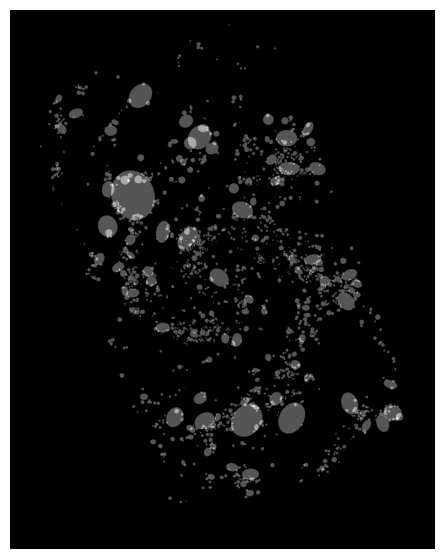

In [13]:
data = hdul[0].data
header = hdul[0].header

#Perform coordinate transforamtion:
wcs = WCS(header)

fig, ax = plt.subplots(figsize=(7,7))
shape = data.shape

final_matrix = np.zeros((shape))

for i,region in enumerate(regions):
    pixel_region = region.to_pixel(wcs)
    mask = pixel_region.to_mask(mode='exact')
    mask_matrix = mask.to_image(shape)
    final_matrix += mask_matrix

    
# Not required to do this as cmap='gray' normalizes the scale so that there is only one color channel.
# max_final_matrix = np.max(final_matrix)
# normal_final_matrix = final_matrix/max_final_matrix


#ax.imshow(data,cmap='gray',vmin=0,vmax=1) # In ground truth value, the background image doesn't show up
plt.ylim(2500,150)
plt.xlim(500,2350)
#final_matrix[final_matrix == 0] = np.nan
plt.imshow(normal_final_matrix,cmap='gray')
plt.gca().set_axis_off() # responsible for removing axes.
#plt.savefig('../NGC0628/masked2.png',bbox_inches='tight',pad_inches = 0)
#plt.colorbar()

In [11]:
np.max(final_matrix)

3.0000000000000155

## Splitting the original image, bubble image and the masked image.

# Creating training images from cutouts

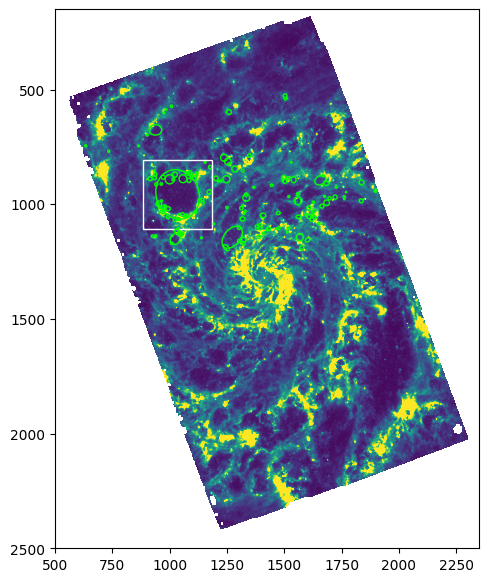

In [12]:
fig, ax = plt.subplots(figsize=(7,7))
#Show map in World Coordinate System transform from axes
#plt.subplot(projection=wcs)


plt.ylim(2500,150)
plt.xlim(500,2350)
ax.imshow(data, vmin=0, vmax=7)

for i,region in enumerate(regions[100:250]):
    pixel_region = region.to_pixel(wcs)
    if region == regions[132]:
        position = (pixel_region.center.x,pixel_region.center.y)
        size = u.Quantity((300,300), u.pixel)
        cutout = Cutout2D(data,position,size)
        cutout.plot_on_original(color='white')
    pixel_region.plot(ax=ax)
# plt.savefig('../Presentation 6_FEB/sample_cutout.png')

In [14]:
# fig, ax = plt.subplots(figsize=(7,7))
# Y_train = np.zeros((1,IMG_HEIGHT,IMG_WIDTH,1),dtype=bool)
# data_original = imread('../../../../../../Applications/dataset>1/stage1_train/original_132.png/mask/original_132.png',as_gray=True)
# mask_ = np.expand_dims(resize(data_original,(128,128), mode='constant',preserve_range=True),axis=-1)
# Y_train = mask_
# print(Y_train)
# plt.imshow(np.squeeze(Y_train[0]))

<Axes: >

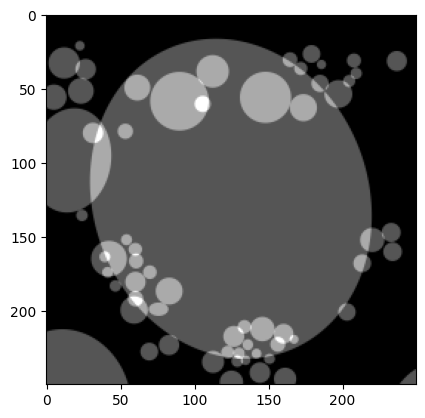

In [15]:
region = regions[132].to_pixel(wcs)
position = (region.center.x,region.center.y)
size = u.Quantity((250,250), u.pixel)

cutout = Cutout2D(final_matrix,position,size)

plt.imshow(cutout.data,cmap='gray')
cutout.plot_on_original(color='white')

In [16]:
shutil.rmtree('../../../../../../Applications/dataset>1/')
parent_folder = '../../../../../../Applications/dataset>1/'
os.makedirs(parent_folder)
original_folder = '../../../../../../Applications/dataset>1/original/'
os.mkdir(original_folder)
# bubble_folder = './dataset/bubble/'
# os.mkdir(bubble_folder)
masked_folder = '../../../../../../Applications/dataset>1/masked/'
os.mkdir(masked_folder)

for i,region in enumerate(regions):
    pixel_region = region.to_pixel(wcs)
    position = (pixel_region.center.x,pixel_region.center.y)
    size = u.Quantity((300,300), u.pixel)
    
    cutout_original = Cutout2D(data,position,size)
    cutout_mask = Cutout2D(final_matrix,position,size)
    
    plt.imshow(cutout_original.data,vmin=0,vmax=7)
    plt.gca().set_axis_off() # responsible for removing axes.
    plt.savefig(f'{original_folder}/original_{i}.png',bbox_inches='tight',pad_inches = 0)
    plt.clf()
    
    plt.imshow(cutout_mask.data,cmap='gray')
    plt.gca().set_axis_off() # responsible for removing axes.
    plt.savefig(f'{masked_folder}/masked_{i}.png',bbox_inches='tight',pad_inches = 0)
    plt.clf()

<Figure size 640x480 with 0 Axes>

## Splitting the data into training and testing data sets

In [17]:
num_of_originals = len([name for name in os.listdir(original_folder)])
num_of_masks = len([name for name in os.listdir(masked_folder)])


In [22]:
os.mkdir('../../../../../../Applications/dataset>1/stage1_test')
os.mkdir('../../../../../../Applications/dataset>1/stage1_train')

num_of_training_images = int(0.9*num_of_originals)
num_of_testing_images = num_of_originals - num_of_training_images

training_idx = next(os.walk(original_folder))[2] #all the ids
random.shuffle(training_idx) #random sampling of all the images ids
id_collector = [] #collects the integer ids that have been used for training set

train_folder = '../../../../../../Applications/dataset>1/stage1_train/'
for iterations in range(num_of_training_images):

    i = int(training_idx[iterations][9:-4])
    id_collector.append(i)
    original_filename = f"original_{i}.png"
    dst_original_folder = f"../../../../../../Applications/dataset>1/stage1_train/{original_filename}"
    os.mkdir(dst_original_folder)
    
    if (os.path.exists(dst_original_folder)):
        dst_image_folder = f"{dst_original_folder}/image"
        os.mkdir(dst_image_folder)

        dst_masked_folder = f"{dst_original_folder}/mask"
        os.mkdir(dst_masked_folder)

        
    masked_filename = f"masked_{i}.png"
    
    src_path_original = os.path.join(original_folder,original_filename)
    src_path_masked = os.path.join(masked_folder,masked_filename)
    
    dst_path_original = os.path.join(dst_image_folder,original_filename)
    dst_path_masked = os.path.join(dst_masked_folder,original_filename)
    
    shutil.copy(src_path_original,dst_path_original)
    shutil.copy(src_path_masked,dst_path_masked)
    
for i in id_collector:
    training_idx.remove(f'original_{i}.png')
    
for iterations in range(num_of_testing_images):

    i = int(training_idx[iterations][9:-4])
    original_filename = f"original_{i}.png"
    dst_original_folder = f"../../../../../../Applications/dataset>1/stage1_test/{original_filename}"
    os.mkdir(dst_original_folder)
    
    if (os.path.exists(dst_original_folder)):
        dst_image_folder = f"{dst_original_folder}/image"
        os.mkdir(dst_image_folder)

        dst_masked_folder = f"{dst_original_folder}/mask"
        os.mkdir(dst_masked_folder)

        
    masked_filename = f"masked_{i}.png"
    
    src_path_original = os.path.join(original_folder,original_filename)
    src_path_masked = os.path.join(masked_folder,masked_filename)
    
    dst_path_original = os.path.join(dst_image_folder,original_filename)
    dst_path_masked = os.path.join(dst_masked_folder,original_filename)
    
    shutil.copy(src_path_original,dst_path_original)
    shutil.copy(src_path_masked,dst_path_masked)
    
shutil.rmtree('../../../../../../Applications/dataset>1/original/')
shutil.rmtree('../../../../../../Applications/dataset>1/masked/')

## Preparing images for the input layer

In [16]:
seed = 42

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = '../../../../../../Applications/dataset>1/stage1_train/'
TEST_PATH = '../../../../../../Applications/dataset>1/stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,1),dtype=np.float32)


print('Resizing training images and masks')
for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/image/' + id_)[:,:,:IMG_CHANNELS]
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH), mode='constant',preserve_range=True)
    X_train[n] = img
    mask_ = imread(path + '/mask/' + id_,as_gray=True)
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT,IMG_WIDTH), mode='constant',preserve_range=True),axis=-1)
    Y_train[n] = mask_

print('Resizing test images')

X_test = np.zeros((len(test_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
sizes_test = []
for n,id_ in tqdm(enumerate(test_ids),total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/image/' + id_)[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0],img.shape[1]])
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH),mode='constant',preserve_range=True)
    X_test[n] = img


Resizing training images and masks


100%|███████████████████████████████████████| 1525/1525 [00:31<00:00, 47.98it/s]


Resizing test images


100%|█████████████████████████████████████████| 170/170 [00:02<00:00, 81.08it/s]


# The reason why mask image looks like this is because we are casting the array into an array of true and false, therefore, overlapping bubbles are much harder and would need to study overlapping segmentation ! I tried with dp.float32 but the accuracy remained constant   64% :( 

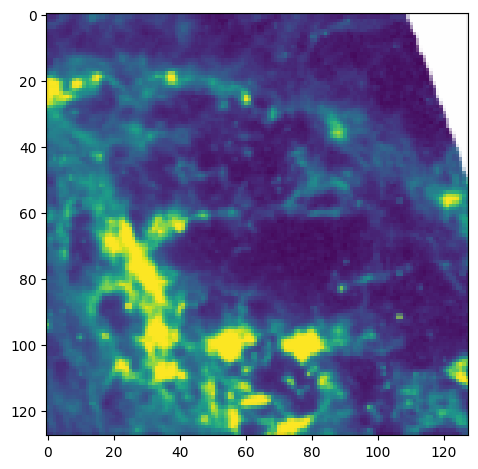

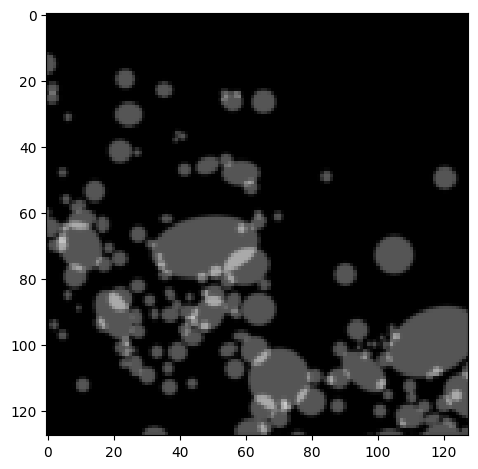

In [18]:
image_x = random.randint(0,len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

# Sanity check on the masked images

In [186]:
# id_ = 'original_134.png'
# TRAIN_PATH = './dataset/stage1_train/'
# path = TRAIN_PATH + id_
# mask_ = imread(path + '/mask/' + id_)
# #print(mask_)
# # mask_ = resize(mask_,(IMG_HEIGHT,IMG_WIDTH), mode='constant',preserve_range=True)
# # mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT,IMG_WIDTH), mode='constant',preserve_range=True),axis=-1)
# plt.imshow(mask_)
# mask_.shape

# U-NET Architecture

In [19]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x:x/255)(inputs)

c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPool2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPool2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPool2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPool2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)


#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1])
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)


outputs = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()



Metal device set to: Apple M1


2023-03-16 16:00:39.088348: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-16 16:00:39.088894: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

 conv2d_15 (Conv2D)             (None, 64, 64, 32)   9248        ['dropout_7[0][0]']              
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_3[0][0]']          
                                )                                                                 
          

In [20]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('bubbles.h5',verbose=1,save_best_only=True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3,monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

results = model.fit(X_train,Y_train,validation_split=0.1,batch_size=16,epochs=25,callbacks=callbacks)


Epoch 1/25


2023-03-16 16:00:55.175771: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-16 16:00:55.867040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 0.3065 - accuracy: 0.6315

2023-03-16 16:01:06.922116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 12s 125ms/step - loss: 0.3065 - accuracy: 0.6315 - val_loss: 0.2759 - val_accuracy: 0.6158
Epoch 2/25
86/86 [==============================] - 10s 118ms/step - loss: 0.2628 - accuracy: 0.6402 - val_loss: 0.2612 - val_accuracy: 0.6158
Epoch 3/25
86/86 [==============================] - 10s 117ms/step - loss: 0.2450 - accuracy: 0.6402 - val_loss: 0.2392 - val_accuracy: 0.6158
Epoch 4/25
86/86 [==============================] - 10s 117ms/step - loss: 0.2189 - accuracy: 0.6402 - val_loss: 0.2165 - val_accuracy: 0.6158
Epoch 5/25
86/86 [==============================] - 10s 117ms/step - loss: 0.2011 - accuracy: 0.6402 - val_loss: 0.2103 - val_accuracy: 0.6158
Epoch 6/25
86/86 [==============================] - 10s 117ms/step - loss: 0.1899 - accuracy: 0.6402 - val_loss: 0.1941 - val_accuracy: 0.6158
Epoch 7/25
86/86 [==============================] - 10s 120ms/step - loss: 0.1814 - accuracy: 0.6402 - val_loss: 0.1872 - val_accuracy: 0.6158
Epoch 8/25

KeyboardInterrupt: 

6/6 [==============================] - 0s 66ms/step


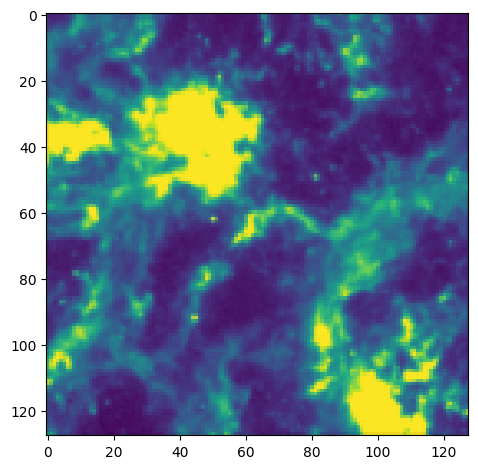

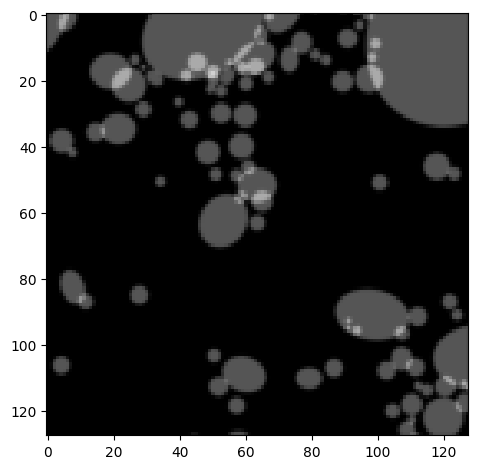

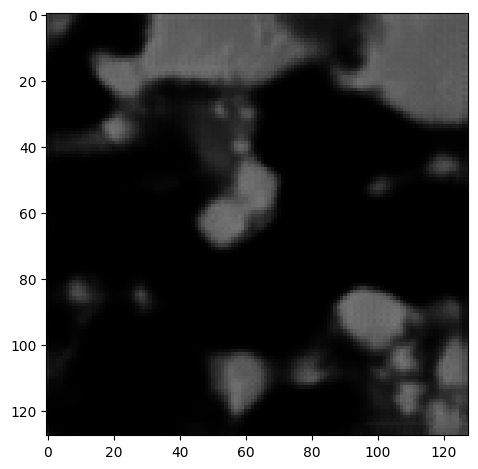

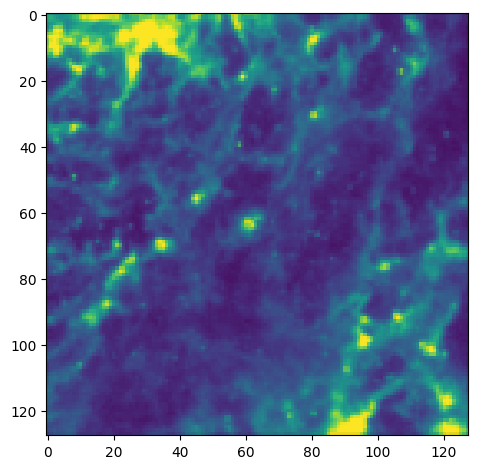

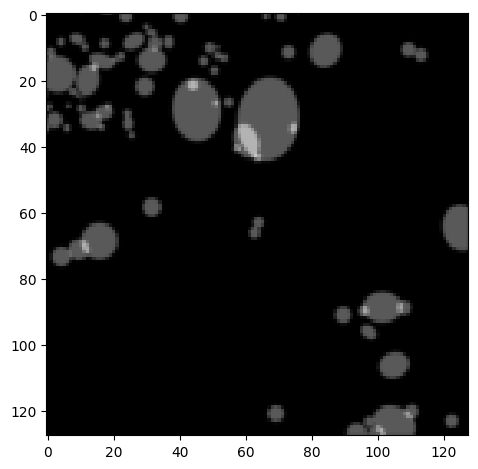

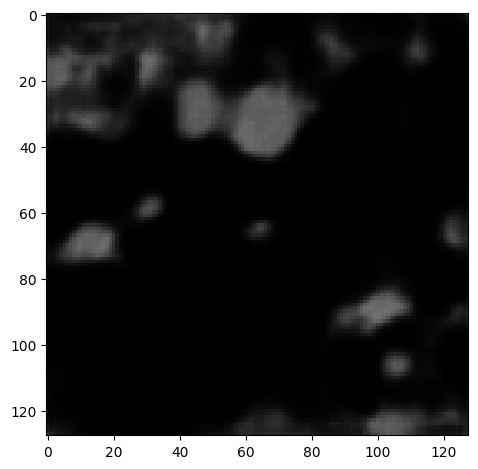

In [22]:
idx = random.randint(0,len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)],verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):],verbose=1)
preds_test = model.predict(X_test,verbose=1)

#binary
preds_train_t = (preds_train > 0.4).astype(np.uint8)
preds_val_t = (preds_val > 0.4).astype(np.uint8)
preds_test_t = (preds_test > 0.4).astype(np.uint8)

ix = random.randint(0,len(preds_train))
imshow(X_train[ix])
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/sample_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()
imshow(np.squeeze(Y_train[ix]))
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/mask_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()
imshow(np.squeeze(preds_train[ix]))
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/prediction_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()

ix = random.randint(0,len(preds_val))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/sample_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/mask_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()
imshow(np.squeeze(preds_val[ix]))
# plt.gca().set_axis_off() # responsible for removing axes.
# plt.savefig(f'./dataset/results/prediction_{ix}.png',bbox_inches='tight',pad_inches = 0)
# plt.clf()
plt.show()


# Instance segmentation -> It treats multiple objects of the same class as distinct instances, therefore, for overlapping bubbles, we need instance segmentation. 

# For instance segmentation, Mask R-CNN is used !